<a href="https://colab.research.google.com/github/vishalgimhan/DeepLearning-Projects/blob/main/Data_Augmentation_for_Image_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+http://github.com/tensorflow/docs
# or
# pip install tensorflow_docs
# pip install tensorflow_datasets

  Cloning http://github.com/tensorflow/docs to /tmp/pip-req-build-l3b2_9sc
  Running command git clone --filter=blob:none --quiet http://github.com/tensorflow/docs /tmp/pip-req-build-l3b2_9sc
  Resolved http://github.com/tensorflow/docs to commit bd1c16109023bcf73755ee0e1552140bf377573c
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2024.10.14.18741-py3-none-any.whl size=182611 sha256=a20c7fb6e709b17c356afe180d2db44c653d068feefd69c22956e63eb879d397
  Stored in directory: /tmp/pip-ephem-wheel-cache-q7z6wt3u/wheels/dc/f6/d6/4fc0428d864e2a937cb170c22121fc6d16de1f285f6ea0e392
Successfully built tensorflow-docs


In [2]:
import urllib

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers
AUTOTUNE = tf.data.experimental.AUTOTUNE

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

import tensorflow_datasets as tfds

import PIL.Image

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 5)

import numpy as np

In [3]:
# Download Image
image_path = tf.keras.utils.get_file("cat.jpg", origin="https://upload.wikimedia.org/wikipedia/commons/b/b6/Felis_catus-cat_on_snow.jpg", extract=True)
#PIL.Image.open(image_path)

2125399/2125399 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


<ipython-input-3-d56b9453042e>:2: UserWarning: Could not extract archive.
  image_path = tf.keras.utils.get_file("cat.jpg", origin="https://upload.wikimedia.org/wikipedia/commons/b/b6/Felis_catus-cat_on_snow.jpg", extract=True)


In [4]:
# Read and decode the image in format of tensor
image_string = tf.io.read_file(image_path)
image = tf.image.decode_jpeg(image_string, channels=3)

In [5]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original Image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented Image')
  plt.imshow(augmented)

# Data Augmentation on a Single Image


In [6]:
flipped = tf.image.flip_left_right(image)
#visualize(image, flipped)

In [8]:
grayscaled = tf.image.rgb_to_grayscale(image)
#visualize(image, tf.squeeze(grayscaled))
#plt.colorbar()

In [9]:
saturated = tf.image.adjust_saturation(image, 3)
#visualize(image, saturated)

In [10]:
bright = tf.image.adjust_brightness(image, 0.4)
#visualize(image, bright)

In [11]:
rotated = tf.image.rot90(image)
#visualize(image, rotated)

In [12]:
cropped = tf.image.central_crop(image, central_fraction=0.5)
#visualize(image, cropped)

# Data Augmentation on a Dataset and Training a Model

In [ ]:
dataset, info = tfds.load('mnist', as_supervised=True, with_info=True) #load the MNIST dataset
train_dataset, test_dataset = dataset['train'], dataset['test']

num_train_examples = info.splits['train'].num_examples #number of training examples is retrieved from the dataset’s metadata.

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
# Function to augment
def convert(image, label): #Converts the image data type to tf.float32 and normalizes it to the range [0, 1].
  image = tf.image.convert_image_dtype(image, tf.float32) # Cost and Normalize the image to [0,1]
  return image, label

def augment(image, label):
  image, label = convert(image, label) #normalize the image
  image = tf.image.convert_image_dtype(image, tf.float32) # Cost and normalize the image to [0,1]
  image = tf.image.resize_with_crop_or_pad(image, 34, 34) # Add 6 pixels of padding
  image = tf.image.random_crop(image, size=[28,28,1]) # Random crop back to 28x28
  image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness
  return image, label

BATCH_SIZE = 64

#Only use a subset of the data so uts easier to overfit, for this tutorial
NUM_EXAMPLES = 2048

In [ ]:
# sets up the training pipeline with data augmentation
augmented_train_batches = (
    train_dataset

    #Only take a subset, so can quickly see the effect
    .take(NUM_EXAMPLES)
    .cache() #Caches the dataset in memory to improve performance during training.
    .shuffle(num_train_examples//4) #Shuffles the dataset to ensure the model sees a varied order of examples in each epoch.

    #Augmentation is added here
    .map(augment, num_parallel_calls = AUTOTUNE) #with parallel processing to speed up the augmentation.
    .batch(BATCH_SIZE) #Groups the dataset into batches of 64
    .prefetch(AUTOTUNE)
)

In [ ]:
non_augmented_train_batches = (
    train_dataset

    #Only take a subset, so can quickly see th effect
    .take(NUM_EXAMPLES)
    .cache()
    .shuffle(num_train_examples//4)

    #No augmentation
    .map(convert, num_parallel_calls = AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

In [ ]:
validation_batches = (
    test_dataset
    .map(convert, num_parallel_calls = AUTOTUNE)
    .batch(2*BATCH_SIZE)
)

In [ ]:
# Create a Neural Network Model

def make_model():
  model = tf.keras.Sequential([
      layers.Flatten(input_shape=(28, 28, 1)),
      layers.Dense(4096, activation='relu'),
      layers.Dense(4096, activation='relu'),
      layers.Dense(10)
  ])
  model.compile(optimizer='adam',
                loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
  return model

# Training the Model without Data Augmentation

In [ ]:
model_without_aug = make_model()

no_aug_history = model_without_aug.fit(non_augmented_train_batches, epochs= 50, validation_data = validation_batches)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 27s 809ms/step - accuracy: 0.6091 - loss: 1.1465 - val_accuracy: 0.8885 - val_loss: 0.3585
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 39s 745ms/step - accuracy: 0.9405 - loss: 0.1672 - val_accuracy: 0.9207 - val_loss: 0.2785
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 768ms/step - accuracy: 0.9819 - loss: 0.0644 - val_accuracy: 0.9207 - val_loss: 0.2997
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 771ms/step - accuracy: 0.9821 - loss: 0.0532 - val_accuracy: 0.9144 - val_loss: 0.3497
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 779ms/step - accuracy: 0.9809 - loss: 0.0581 - val_accuracy: 0.9238 - val_loss: 0.3296
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 40s 739ms/step - accuracy: 0.9949 - loss: 0.0232 - val_accuracy: 0.9206 - val_loss: 0.3626
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 763ms/step - accuracy: 0.9891 - loss: 0.0266 - val_accuracy: 0.9238 - val_loss: 0.3659
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 766ms/step - accuracy: 0.9958 - loss: 0.0121 - val_accu

# Training the Model with Augmented Data

In [ ]:
model_with_aug = make_model()

aug_history = model_with_aug.fit(augmented_train_batches, epochs= 50, validation_data = validation_batches)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 32s 937ms/step - accuracy: 0.2336 - loss: 2.7722 - val_accuracy: 0.6965 - val_loss: 1.0988
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 30s 939ms/step - accuracy: 0.5120 - loss: 1.4309 - val_accuracy: 0.8086 - val_loss: 0.7375
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.6858 - loss: 0.9778 - val_accuracy: 0.8537 - val_loss: 0.5124
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 30s 960ms/step - accuracy: 0.7481 - loss: 0.8100 - val_accuracy: 0.8843 - val_loss: 0.3996
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 962ms/step - accuracy: 0.7852 - loss: 0.6629 - val_accuracy: 0.8813 - val_loss: 0.3812
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 31s 978ms/step - accuracy: 0.7859 - loss: 0.6586 - val_accuracy: 0.8835 - val_loss: 0.3389
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.8209 - loss: 0.5461 - val_accuracy: 0.9123 - val_loss: 0.2825
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 31s 941ms/step - accuracy: 0.8106 - loss: 0.5706 - val_accuracy: 

Accuracy of augmented model is higher than non augmented

(0.75, 1.0)

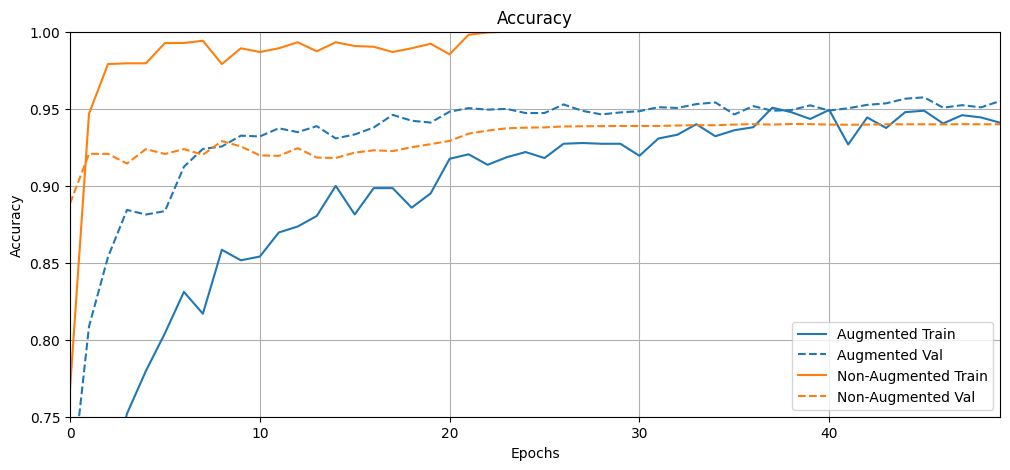

In [ ]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"Augmented": aug_history, "Non-Augmented": no_aug_history}, metric = "accuracy")
plt.title("Accuracy")
plt.ylim([0.75, 1])

Non augmented model is overfitting the dataset

Augmented model fits well